# Raport projektowy – Ocena jakości wina czerwonego Vinho Verde

## Przedstawienie problemu
Celem projektu było przygotowanie modelu uczenia maszynowego, który będzie w stanie z zadowalającą skutecznością klasyfikować wina czerwone gatunku Vinho Verde z północy Portugalii do kategorii jakościowych (od 1 do 10) na podstawie ich właściwości chemicznych. Klasyfikacja jakości wina jest kluczowa zarówno dla producentów, jak i konsumentów, ponieważ wpływa na wartość rynkową oraz decyzje zakupowe. Dlatego stworzenie modelu, który potrafi dokładnie przewidywać jakość wina, jest istotnym krokiem w kierunku optymalizacji procesów produkcyjnych oraz zwiększenia satysfakcji klientów.

## Dane
Do przeprowadzenia analizy wykorzystano zestaw danych, który zawierał informacje o 1599 próbkach wina czerwonego Vinho Verde. Każda próbka została opisana za pomocą 11 zmiennych wejściowych oraz jednej zmiennej wyjściowej. Dane te pozwalają na dokładne zbadanie wpływu poszczególnych właściwości chemicznych na ogólną jakość wina.

### Lista zmiennych wejściowych:
- **Kwasowość stała (Fixed acidity) (g/L)**: Ilość stałych kwasów w winie, wpływających na jego smak i trwałość.
- **Kwasowość lotna (Volatile acidity) (g/L)**: Ilość lotnych kwasów, które mogą powodować nieprzyjemne zapachy w winie.
- **Zawartość kwasu cytrynowego (Citric acid) (g/L)**: Kwas cytrynowy wpływa na świeżość smaku wina.
- **Zawartość cukru resztkowego (Residual sugar) (g/L)**: Ilość cukru pozostającego po fermentacji, wpływająca na słodycz wina.
- **Zawartość chlorków (Chlorides) (g/L)**: Chlorki mogą wpływać na słoność smaku wina.
- **Zawartość wolnego dwutlenku siarki (Free sulfur dioxide) (mg/L)**: Wolny dwutlenek siarki działa jako konserwant, zapobiegając utlenianiu i psuciu wina.
- **Zawartość całkowita dwutlenku siarki (Total sulfur dioxide) (mg/L)**: Całkowita ilość dwutlenku siarki, zarówno wolnego, jak i związanego.
- **Gęstość (Density) (g/cm³)**: Gęstość wina, która może być wskaźnikiem jego zawartości alkoholu i ekstraktu.
- **pH (pH) (wartości od 0 do 14)**: Skala kwasowości wina, wpływająca na jego stabilność mikrobiologiczną.
- **Zawartość siarczanów (Sulphates) (g/L)**: Siarczany mogą wpływać na aromat i smak wina.
- **Zawartość alkoholu (Alcohol) (%)**: Procentowa zawartość alkoholu, która jest jednym z głównych czynników wpływających na jakość wina.

### Zmienna wyjściowa:
- **Jakość (Quality) (ocena od 0 do 10)**: Ocena jakości wina na skali od 0 do 10, gdzie wyższa wartość oznacza lepszą jakość.

W celu przeprowadzenia analizy i budowy modelu, dane zostały odpowiednio przetworzone i podzielone na zestawy treningowe oraz testowe. Model uczenia maszynowego został następnie wytrenowany na zestawie treningowym i jego skuteczność była oceniana na zestawie testowym. 


Link do danych: [Dane](https://github.com/UEPP40/PUM/blob/c1ab27e52bc82cc151bb217b27bd25dfd057d9e8/winequality-red.csv)


In [325]:
# Standard libraries
import math
import logging
from collections import Counter
from typing import Any, Dict, Optional, Tuple

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib as hl
import seaborn as sb
import matplotlib.pyplot as plt


# Scikit-learn libraries for preprocessing and metrics
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, label_binarize, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, auc, precision_recall_curve)

# Scikit-learn libraries for model selection
from sklearn.model_selection import (GridSearchCV, KFold, cross_validate, train_test_split, 
                                     RandomizedSearchCV, StratifiedKFold, cross_val_score)

# Scikit-learn libraries for models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# Scikit-learn libraries for pipeline
from sklearn.pipeline import make_pipeline

# Imbalanced-learn libraries
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

In [326]:
# Define the file path and separator
file_path = 'winequality-red.csv'
separator = ";"

# Load the data from the CSV file into a DataFrame
try:
    wineDataFrame = pd.read_csv(file_path, sep=separator)
    print("Data successfully loaded into DataFrame.")
except FileNotFoundError:
    print(f"File not found: {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

# Display the first 5 records of the DataFrame
print("\nFirst 5 records of the dataset:")
display(wineDataFrame.head(5))

# Display basic information about the DataFrame
print("\nBasic information about the dataset:")
display(wineDataFrame.info())

# Display descriptive statistics of the DataFrame
print("\nDescriptive statistics of the dataset:")
display(wineDataFrame.describe())
OGwdf = wineDataFrame.describe()

# Check for missing values in the DataFrame
print("\nChecking for missing values in the dataset:")
display(wineDataFrame.isnull().sum())

# Display the shape of the DataFrame
print(f"\nThe dataset has {wineDataFrame.shape[0]} rows and {wineDataFrame.shape[1]} columns.")

Data successfully loaded into DataFrame.

First 5 records of the dataset:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5



Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   object 
 3   residual sugar        1599 non-null   object 
 4   chlorides             1599 non-null   object 
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1595 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(8), int64(1), object(3)
memory usage: 150.0+ KB


None


Descriptive statistics of the dataset:


,fixed acidity,volatile acidity,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1595.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,15.756098,46.467792,0.996751,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,10.638410,32.895324,0.001886,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,-29.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,13.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,21.000000,62.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000



Checking for missing values in the dataset:


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 4
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


The dataset has 1599 rows and 12 columns.


In [327]:
# Define a function to clean the DataFrame
def clean_data(df):
    # Remove non-ASCII characters from all columns
    for column in df.columns:
        df[column] = df[column].astype(str).str.replace(r'[^\x00-\x7F]+', '', regex=True)

    # Convert all columns to numeric type, coercing errors to NaN
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    # Display basic information about the DataFrame
    print("\nInitial DataFrame Information:")
    print(df.info())

    # Remove duplicate rows from the DataFrame
    # initial_shape = df.shape
    # df.drop_duplicates(inplace=True)
    # final_shape = df.shape
    # print(f"\nDuplicate rows removed. Initial shape: {initial_shape}, final shape: {final_shape}.")

    # Replace NaN values with the median of the respective column
    df.fillna(df.median(), inplace=True)
    print("\nNaN values replaced with column medians.")

    # Display basic information about the cleaned DataFrame
    print("\nFinal DataFrame Information:")
    print(df.info())
    print(f"DataFrame shape: {df.shape}")

    # Display the number of null values in each column
    print("\nNumber of null values in each column:")
    print(df.isnull().sum())

    return df

# Clean the DataFrame
wineDataFrame = clean_data(wineDataFrame)


Initial DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1596 non-null   float64
 3   residual sugar        1598 non-null   float64
 4   chlorides             1596 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1595 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None

NaN values replaced with column medians.

Final DataFrame Information:
<class 'pandas.co

Podstawwowym problemem napotkanym w danych była duża rozbieżnośc pod względem ilość rekordów należących do poszczególnych klas jakościowych. Klasy 1, 2, 9 i 10 nie posiadały żadnych rekordów, a klasy 3, 4 i 8 posiadały ich niewiele. Zbiór danych był zdecydowanie zdominowany przez klasy 5, 6 i 7.

Następnie dane zostały poddane procesowi pre-processingu. Wykonano następujące kroki:

Pozbyto się zbędnych znaków z wartości danych wejściowych.
Przekonwertowano typ danych dla wszystkich kolumn na numeryczny.
Odrzucono wszystkie rekordy posiadające puste wartości w którejkolwiek z kolumn.
Odrzucono wszystkie rekordy z wartościami skrajnymi w którejkolwiek z kolumn.

Odrzucono także cechy o niskiej relewancji statystycznej. Za pułap, dla którego cecha została uznawana za istotną statystycznie, przyjęto korelację ze zmienną wynikową o wartości większej 0.1.



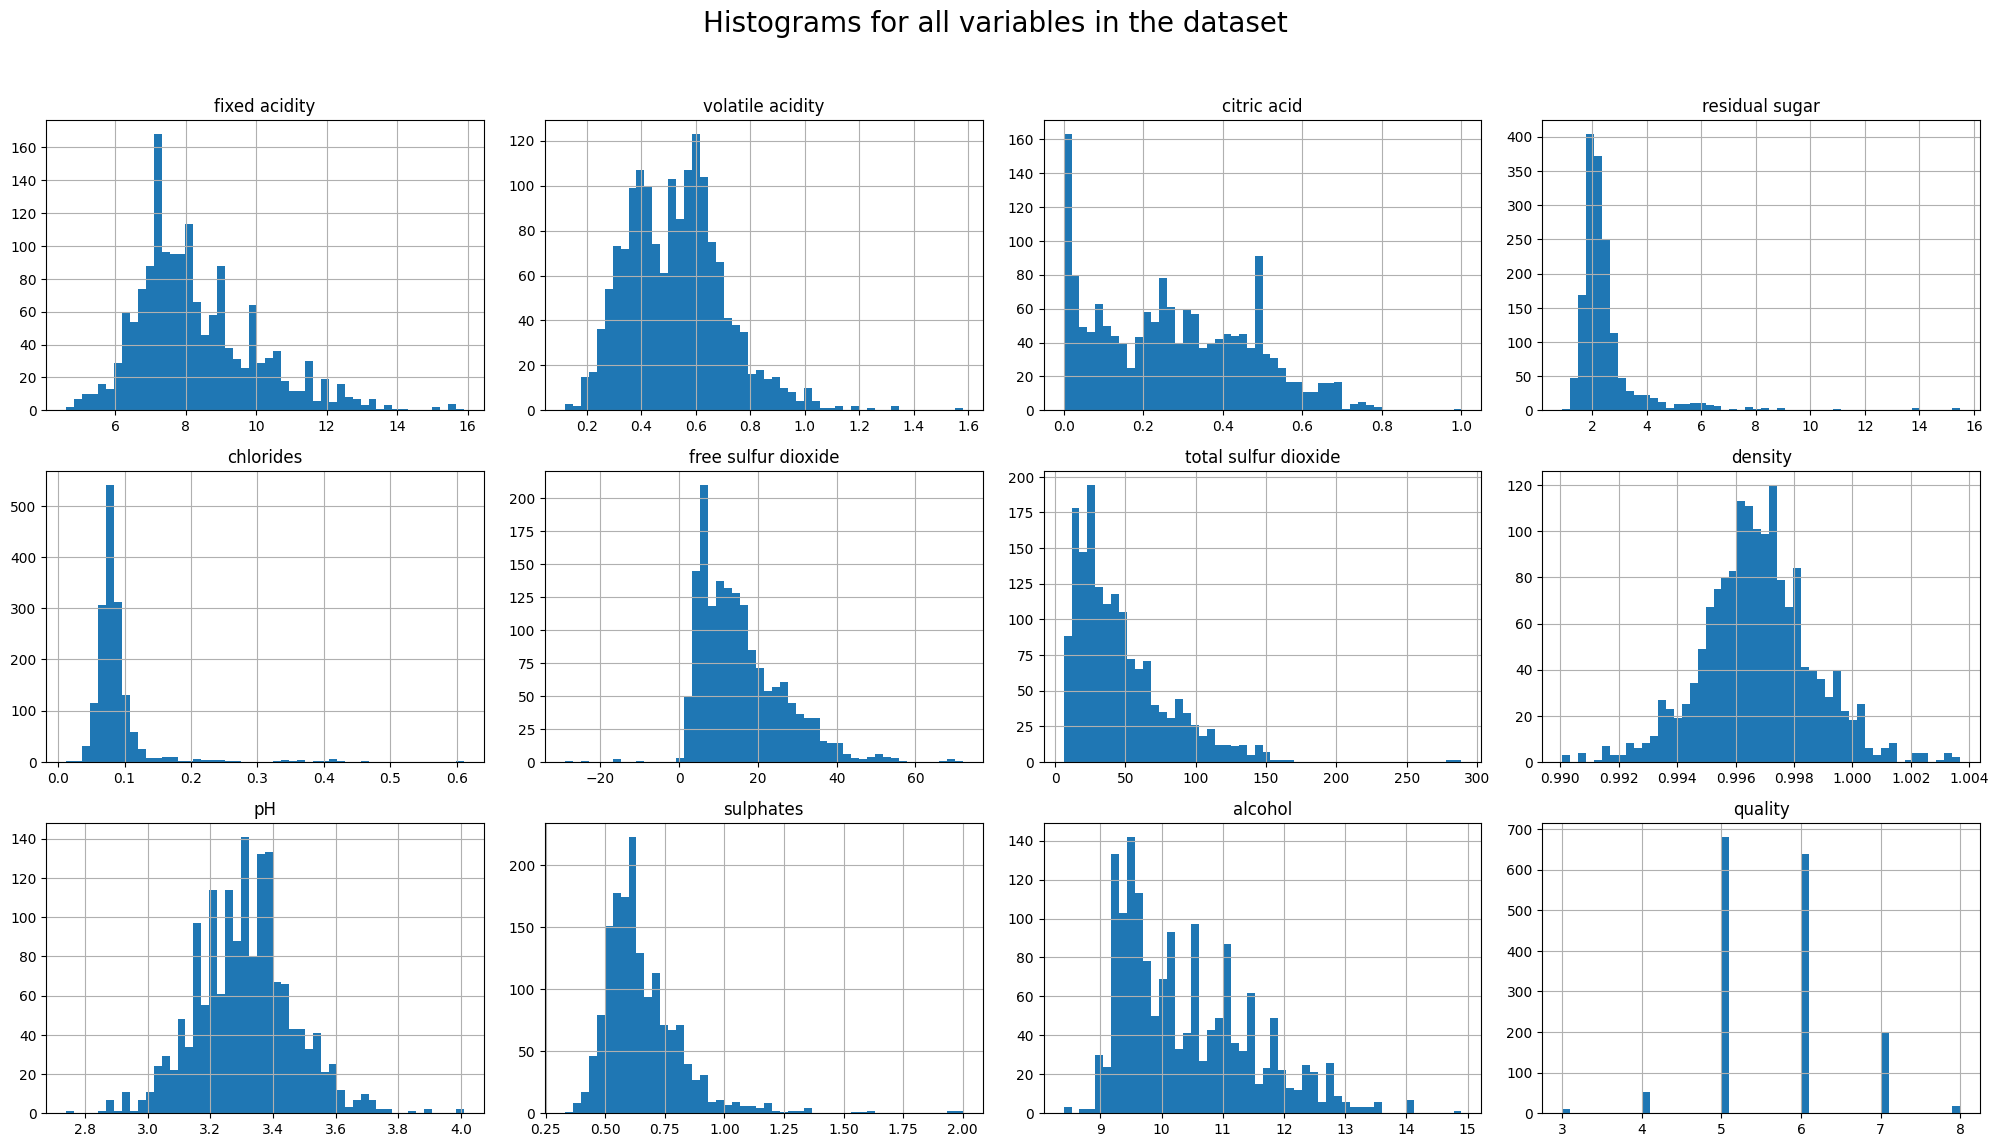

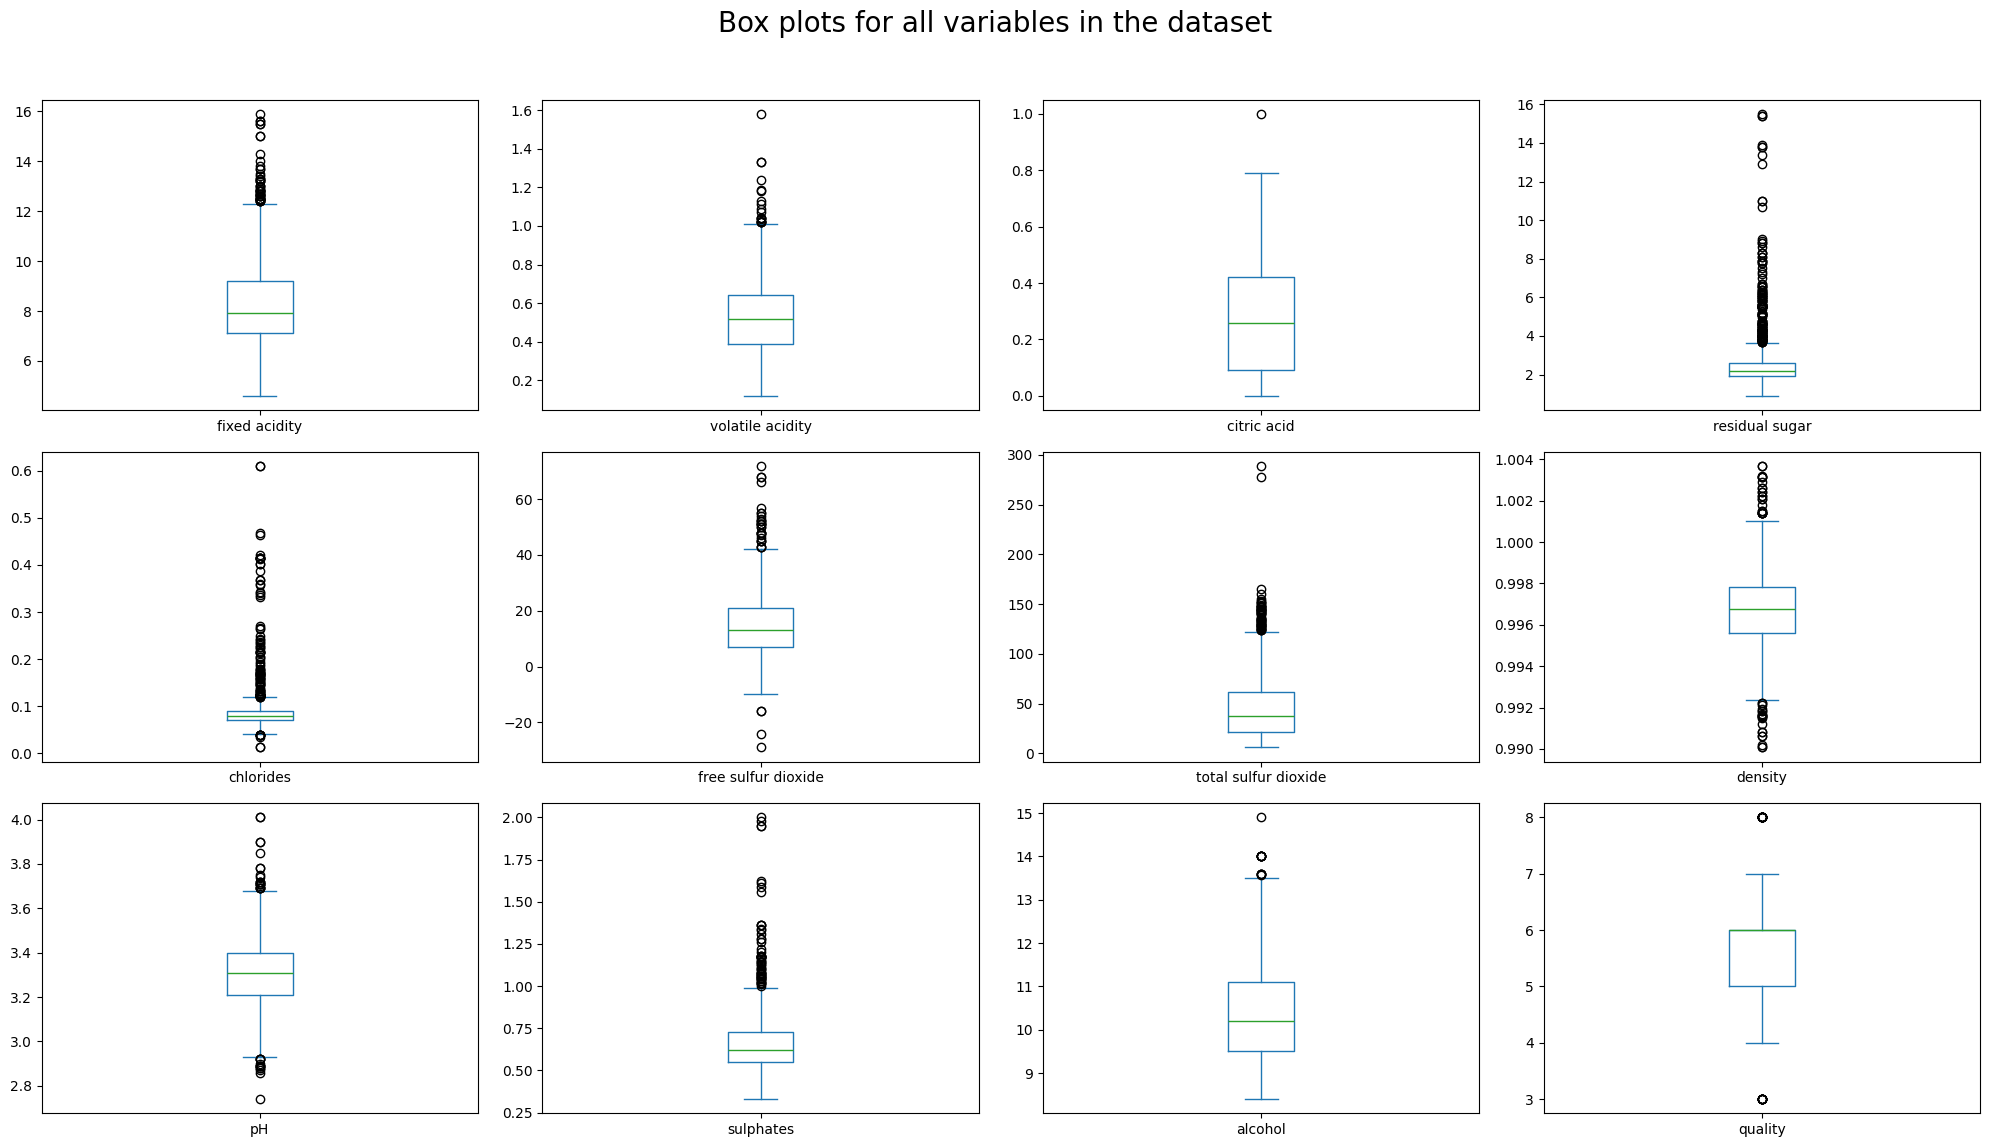

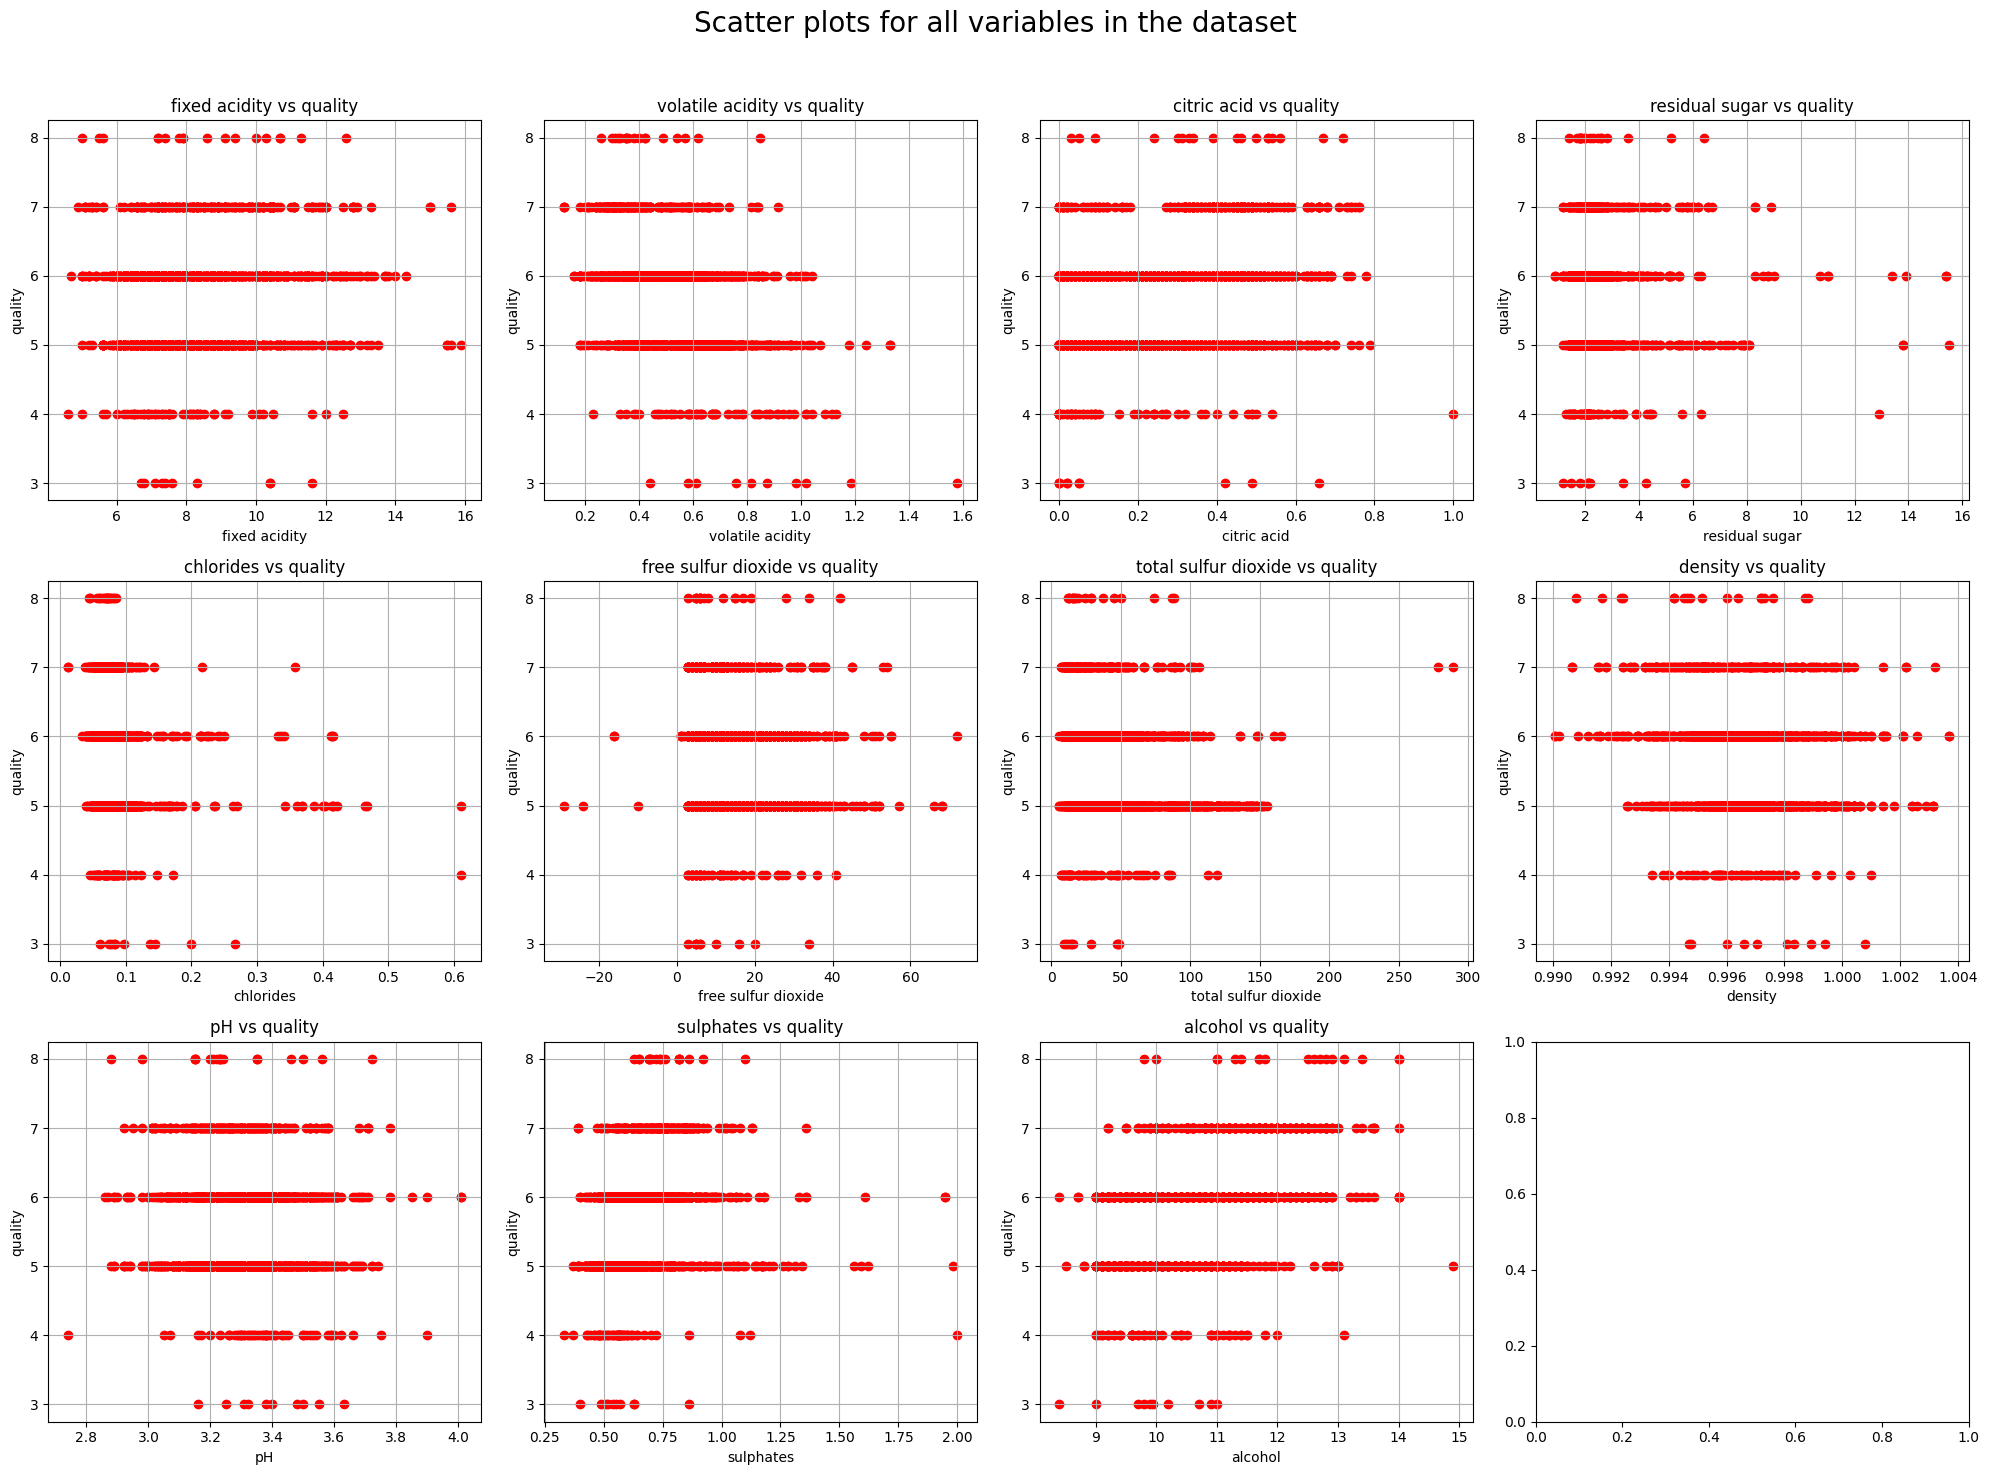

In [328]:
# Draw histograms for all variables
wineDataFrame.hist(bins=50, figsize=(20,15), layout=(wineDataFrame.shape[1]//4+1,4))
plt.suptitle('Histograms for all variables in the dataset', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Improves appearance
plt.show()

# Draw box plots for all variables
wineDataFrame.plot(kind='box', subplots=True, layout=(wineDataFrame.shape[1]//4+1,4), figsize=(20,15))
plt.suptitle('Box plots for all variables in the dataset', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Improves appearance
plt.show()

features = wineDataFrame.columns.drop('quality')  # Get all features except 'quality'
fig, axs = plt.subplots(len(features)//4+1, 4, figsize=(20,15))
for i, feature in enumerate(features):
    axs[i//4, i%4].scatter(wineDataFrame[feature], wineDataFrame['quality'], color='r')
    axs[i//4, i%4].set_title(f'{feature} vs quality')
    axs[i//4, i%4].set_xlabel(feature)
    axs[i//4, i%4].set_ylabel('quality')
    axs[i//4, i%4].grid()
plt.suptitle('Scatter plots for all variables in the dataset', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Improves appearance
plt.show()

Outliers removed from column 'fixed acidity'.
Outliers removed from column 'volatile acidity'.
Outliers removed from column 'citric acid'.
Outliers removed from column 'residual sugar'.
Outliers removed from column 'chlorides'.
Outliers removed from column 'free sulfur dioxide'.
Outliers removed from column 'total sulfur dioxide'.
Outliers removed from column 'density'.
Outliers removed from column 'pH'.
Outliers removed from column 'sulphates'.
Outliers removed from column 'alcohol'.

DataFrame Information After Outlier Removal:
<class 'pandas.core.frame.DataFrame'>
Index: 1512 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1512 non-null   float64
 1   volatile acidity      1512 non-null   float64
 2   citric acid           1512 non-null   float64
 3   residual sugar        1512 non-null   float64
 4   chlorides             1512 non-null   float64
 5   

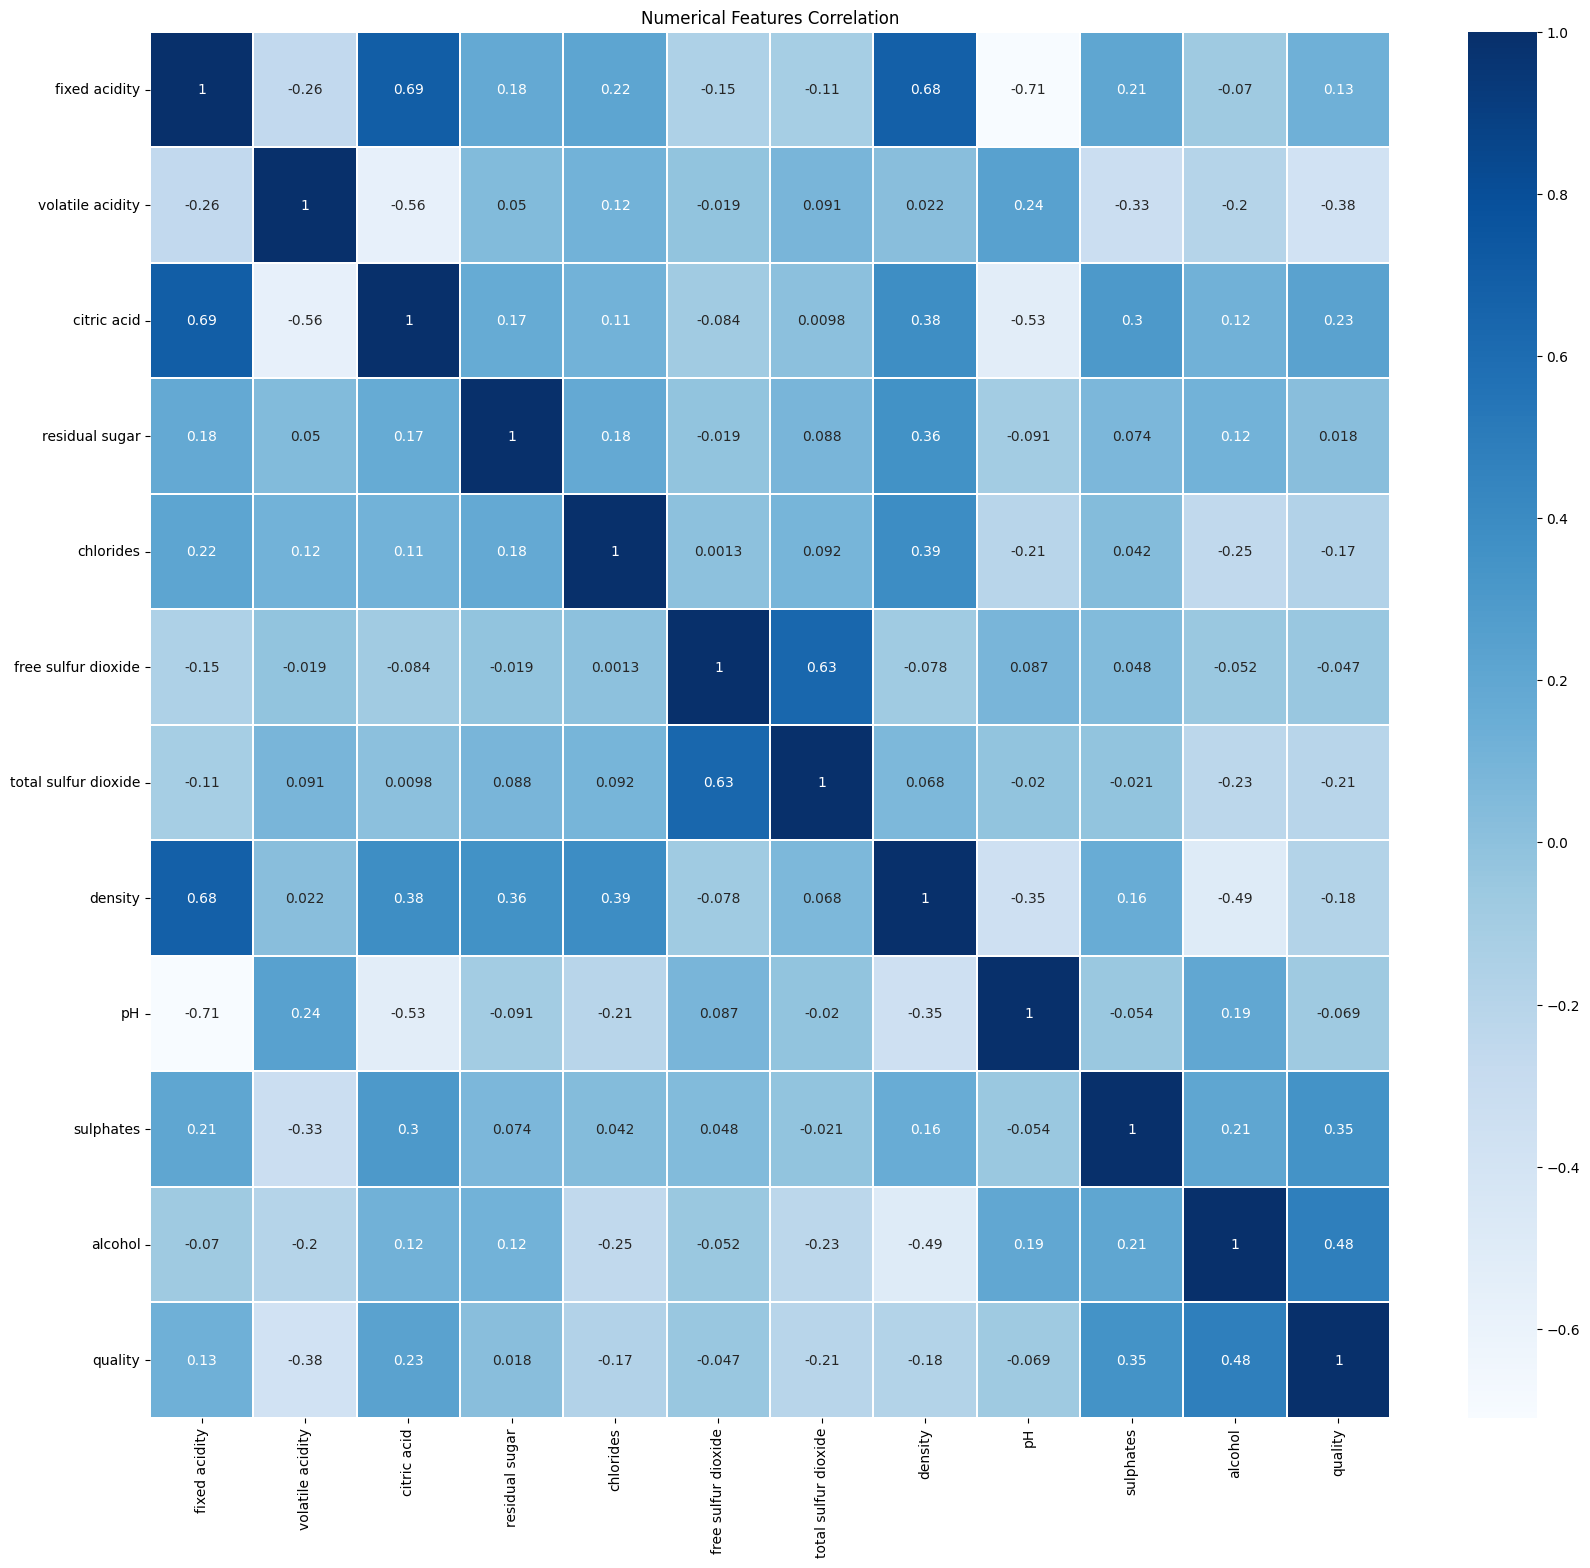

Relevant features (correlation with 'quality' > 0.1):
 fixed acidity           0.125055
volatile acidity        0.381802
citric acid             0.233497
chlorides               0.174247
total sulfur dioxide    0.208884
density                 0.180451
sulphates               0.352092
alcohol                 0.483027
quality                 1.000000
Name: quality, dtype: float64

Non-relevant features (correlation with 'quality' <= 0.1):
 residual sugar         0.018442
free sulfur dioxide    0.047492
pH                     0.068772
Name: quality, dtype: float64

DataFrame after keeping only relevant features:
<class 'pandas.core.frame.DataFrame'>
Index: 1512 entries, 0 to 1598
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1512 non-null   float64
 1   volatile acidity      1512 non-null   float64
 2   citric acid           1512 non-null   float64
 3   chlorides            

In [329]:
# Define a function to remove outliers and analyze correlations
def analyze_data(df):
    # Remove outliers from all numeric columns except 'quality'
    for column in df.columns:
        if column != 'quality' and pd.api.types.is_numeric_dtype(df[column]):
            Q1 = df[column].quantile(0.10)
            Q3 = df[column].quantile(0.90)
            IQR = Q3 - Q1

            filter = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)
            df = df.loc[filter]
            print(f"Outliers removed from column '{column}'.")

    # Display basic information about the DataFrame
    print("\nDataFrame Information After Outlier Removal:")
    print(df.info())

    # Create a correlation heatmap
    plt.figure(figsize = (20, 18)) 
    sns.heatmap(df.corr(), annot = True, linewidths = 0.1, cmap = 'Blues')
    plt.title('Numerical Features Correlation')
    plt.show()

    # Identify features that have a correlation with 'quality' greater than 0.1
    corr_matrix = df.corr()
    cor_target = abs(corr_matrix["quality"])
    relevant_features = cor_target[cor_target>0.1]

    # Print relevant and non-relevant features
    print("Relevant features (correlation with 'quality' > 0.1):\n", relevant_features)
    print("\nNon-relevant features (correlation with 'quality' <= 0.1):\n", cor_target[cor_target<=0.1])

    # Keep only the relevant features in the DataFrame
    df = df[relevant_features.index]
    print("\nDataFrame after keeping only relevant features:")
    print(df.info())

    return df

wineDataFrame = analyze_data(wineDataFrame)

In [330]:
# Display descriptive statistics of the DataFrame
print("\nDescriptive statistics of the dataset:")
display(OGwdf)

# Display descriptive statistics of the DataFrame
print("\nDescriptive statistics of the dataset:")
display(wineDataFrame.describe())



Descriptive statistics of the dataset:


,fixed acidity,volatile acidity,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1595.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,15.756098,46.467792,0.996751,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,10.638410,32.895324,0.001886,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,-29.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,13.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,21.000000,62.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000



Descriptive statistics of the dataset:


,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
count,1512.00000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000
mean,8.31541,0.527216,0.265119,0.080589,45.177910,0.996692,0.644802,10.449901,5.643519
std,1.75035,0.177493,0.191672,0.019139,31.039147,0.001847,0.135563,1.055876,0.804873
min,4.60000,0.120000,0.000000,0.012000,6.000000,0.990070,0.330000,8.400000,3.000000
25%,7.10000,0.390000,0.090000,0.070000,22.000000,0.995570,0.550000,9.500000,5.000000
50%,7.90000,0.520000,0.250000,0.079000,37.000000,0.996700,0.620000,10.200000,6.000000
75%,9.20000,0.640000,0.420000,0.089000,60.000000,0.997800,0.720000,11.100000,6.000000
max,15.60000,1.330000,0.790000,0.176000,165.000000,1.003200,1.220000,14.000000,8.000000


In [331]:
# Define a function to split the DataFrame and save to CSV
def prepareDataToCSV(df):
    # Separate the DataFrame into features and target
    wineData = df.drop(columns=["quality"])
    wineRatings = df["quality"]
    print("Data has been split into features and target.")

    # Save the features and target to CSV files
    wineData.to_csv('wineData.csv', index=False)
    print("Features have been saved to 'wineData.csv'.")
    
    wineRatings.to_csv('wineRatings.csv', index=False)
    print("Target has been saved to 'wineRatings.csv'.")

# Split the DataFrame and save to CSV
prepareDataToCSV(wineDataFrame)

Data has been split into features and target.
Features have been saved to 'wineData.csv'.
Target has been saved to 'wineRatings.csv'.


In [332]:
def initialize_data(scaler_type: Optional[str] = None) -> Tuple[pd.DataFrame, pd.Series]:
    
    # Pobranie danych z plików .csv
    X = pd.read_csv('wineData.csv')
    y = pd.read_csv('wineRatings.csv')
    y = y.values.ravel()
    
    #Informacje o danych do logów
    logging.info(f"X shape: {X.shape}, y shape: {y.shape}")

    #Przeskalowanie danych przy użyciu obiektu MinMaxScaler
    if scaler_type in ["minmax", "standard"]:
        scaler = MinMaxScaler() if scaler_type == "minmax" else StandardScaler()
        X = scaler.fit_transform(X)
        logging.info(f"Data scaled using {scaler_type} scaler.")
    else:
        logging.info("No scaling applied.")

    return X, y

In [333]:
#Funkcja definiująca strategię próbkowania
def sampling_strategy(y):
    unique, counts = np.unique(y, return_counts=True)
    max_count = max(counts)
    return {class_label: max(int(1 * max_count), count) for class_label, count in zip(unique, counts)}

#Funkcja dzieląca dane na zbiór treningowy i testowy oraz nakladająca oversampler
def initialize_and_split_data(scaler_type: str, method: str = 'none', featureselection: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X, y = initialize_data(scaler_type)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if featureselection == True:
        sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
        sel.fit(X_train, y_train)
        X_train = sel.transform(X_train)
        X_test = sel.transform(X_test)

    if method == 'smote':
        strategy = sampling_strategy(y_train)
        oversampler = SMOTE(sampling_strategy=strategy, k_neighbors=2, random_state=42)
        X_train, y_train = oversampler.fit_resample(X_train, y_train)
        logging.info(f"Applied {method} to handle class imbalance in the training data.")

    return X_train, X_test, y_train, y_test

#Funkcja ewaluująca model
def cross_validation_and_evaluation(X_train: np.ndarray, y_train: np.ndarray, model: Any, cv_splits: int = 3, random_state: int = 42) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, list, Dict[str, Any]]:
    pipe = make_pipeline(model)
    # Perform cross-validation
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    cv_results = cross_validate(pipe, X_train, y_train, cv=kfold, return_train_score=True)
    logging.info(f"Cross-validation results: {cv_results}")
    return cv_results, cv_results['test_score'].mean()

#Funkcja znajująca najlepsze hiperparametry
def optimize_hyperparameters(estimator, X_train: np.ndarray, y_train: np.ndarray, param_grid: Dict[str, Any], n_iter: int = 20, random_state: int = 42) -> RandomizedSearchCV:
    random_search = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, n_iter=n_iter, random_state=random_state, n_jobs=-1, verbose=2)
    random_search.fit(X_train, y_train)
    logging.info(f"Best accuracy score: {random_search.best_score_ * 100:.2f}%")
    logging.info(f"Best parameters: {random_search.best_params_}")
    return random_search.best_estimator_


In [334]:
# Function to generate classification report
def generate_report(y_test: Any, y_pred: Any) -> Dict[str, Any]:
    classes = [3, 4, 5, 6, 7, 8]
    report = classification_report(y_test, y_pred, labels=classes, output_dict=True, zero_division=1)
    logging.info("Classification report:\n%s", classification_report(y_test, y_pred, labels=classes, zero_division=1))
    logging.info("Confusion matrix:\n%s", confusion_matrix(y_test, y_pred, labels=classes))
    return report

# Function to plot histogram
def plot_histogram(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).plot.hist(ax=ax, alpha=0.5)
    ax.set_title('Actual vs Predicted Values')
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.legend(['Actual', 'Predicted'])

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df.plot(ax=ax, marker='o')
    ax.set_title('Actual vs Predicted Values')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend(['Actual', 'Predicted'])

# Function to plot classification report
def plot_classification_report(report: Dict[str, Any], ax: plt.Axes) -> None:
    report_df = pd.DataFrame(report).transpose().drop(columns='support')
    report_df.plot(kind='bar', ax=ax)
    ax.set_title('Classification Report Metrics')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend(loc='lower right')

# Function to plot confusion matrix
def plot_confusion_matrix(matrix: np.ndarray, classes: list, ax: plt.Axes) -> None:
    sns.heatmap(matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, ax=ax, cmap='Blues')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')



# Function to display all plots
def display_plots(y_fold_test: np.ndarray, y_pred: np.ndarray, report: Dict[str, Any], cv_results: Dict[str, Any], accuracy_without_optimization: float, accuracy_with_optimization: float) -> None:
    fig, axs = plt.subplots(3, 2, figsize=(16, 16))
    classes = [3, 4, 5, 6, 7, 8]
    
    plot_actual_vs_predicted(y_fold_test, y_pred, axs[0, 0])
    plot_confusion_matrix(confusion_matrix(y_fold_test, y_pred, labels=classes), classes, axs[0, 1])
    plot_classification_report(report, axs[1, 0])
    plot_histogram(y_fold_test, y_pred, axs[2, 1])
    
    if 'test_score' in cv_results and 'train_score' in cv_results:
        axs[1, 1].plot(cv_results['test_score'], label='Test Score')
        axs[1, 1].plot(cv_results['train_score'], label='Train Score')
        axs[1, 1].set_title('Cross-validation Results with Optimized Hyperparameters')
        axs[1, 1].set_xlabel('Fold Index')
        axs[1, 1].set_ylabel('Accuracy')
        axs[1, 1].legend()
        axs[2, 0].bar(['Without Optimization', 'With Optimization'], [accuracy_without_optimization, accuracy_with_optimization])
        axs[2, 0].set_title('Comparison of Model Performance')
        axs[2, 0].set_ylabel('Mean Accuracy Score')
    else:
        axs[1, 1].text(0.5, 0.5, 'No CV Results Available', ha='center', va='center')
        axs[1, 1].set_axis_off()
        axs[2, 0].text(0.5, 0.5, 'No Optimization Results Available', ha='center', va='center')
        axs[2, 0].set_axis_off()

    


    plt.tight_layout()
    plt.show()

In [335]:
def gaussian_naive_bayes_main():
    try:
        #Podział danych na zbior testowy i treningowy
        X_train, X_test, y_train, y_test = initialize_and_split_data("standard", 'none', False)
        logging.info("Data initialization and splitting complete.")

        #Utworzenie obiektu modelu
        gnb = GaussianNB()

        #Wytrenowanie i wstepna ocena modelu
        cv_results, accuracy_without_optimization = cross_validation_and_evaluation(X_train, y_train, gnb)

        np.random.seed(0)  # for reproducibility
        random_priors = np.random.dirichlet(np.ones(6), size=1)[0]

        #Hiperparametryzacja
        param_grid = {
            'var_smoothing': np.logspace(0, -9, num=100),
            'priors': [random_priors, None]
        }
        gnbOPT = optimize_hyperparameters(gnb, X_train, y_train, param_grid, n_iter = 200)

        #Walidacja krzyżowa modelu ze zoptymalizowanymi hiperparametrami
        cv_resultsOPT, accuracy_with_optimization = cross_validation_and_evaluation(X_train, y_train, gnbOPT)

        #Predykcje na zbiorze testowym
        y_pred_optimized = gnbOPT.predict(X_test)

        #Generacja raportu dla modelul
        report_optimized = generate_report(y_test, y_pred_optimized)

        #Generacja wykresów dla modelu
        display_plots(y_test, y_pred_optimized, report_optimized, cv_resultsOPT, accuracy_without_optimization, accuracy_with_optimization)
        return gnbOPT
    except Exception as e:
        logging.error("An error occurred during model evaluation and plotting.", exc_info=True)


In [336]:
def knn_main():
    try:
        #Podział danych na zbior testowy i treningowy
        X_train, X_test, y_train, y_test = initialize_and_split_data("standard", 'smote', False)
        logging.info("Data initialization and splitting complete.")

        #Utworzenie obiektu modelu
        knn = KNeighborsClassifier()

        #Wytrenowanie i wstepna ocena modelu
        best_params = {}
        cv_results, accuracy_without_optimization = cross_validation_and_evaluation(X_train, y_train, knn)

        #Hiperparametryzacja
        param_grid = {
            'n_neighbors': np.arange(1, 101),
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
            'p': [1, 2, 3, 4],
            'n_jobs': [-1, None],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': np.arange(10, 61, 10)
        }
        knnOPT = optimize_hyperparameters(knn, X_train, y_train, param_grid, n_iter = 600)

        #Walidacja krzyżowa modelu ze zoptymalizowanymi hiperparametrami
        cv_resultsOPT, accuracy_with_optimization = cross_validation_and_evaluation(X_train, y_train, knnOPT)

        #Predykcje na zbiorze testowym
        y_pred_optimized = knnOPT.predict(X_test)

        #Generacja raportu dla modelu
        report_optimized = generate_report(y_test, y_pred_optimized)

        #Generacja wykresów dla modelu
        display_plots(y_test, y_pred_optimized, report_optimized, cv_resultsOPT, accuracy_without_optimization, accuracy_with_optimization)
        return knnOPT
    except Exception as e:
        logging.error("An error occurred during model evaluation and plotting.", exc_info=True)

In [337]:
def random_forest_main():
    try:
        #Podział danych na zbior testowy i treningowy
        X_train, X_test, y_train, y_test = initialize_and_split_data("standard", 'smote', False)
        logging.info("Data initialization and splitting complete.")

        #Utworzenie obiektu modelu
        rf = RandomForestClassifier()


        #Wytrenowanie i wstepna ocena modelu
        cv_results, accuracy_without_optimization = cross_validation_and_evaluation(X_train, y_train, rf)

        #Hiperparametryzacja
        param_grid = {
            'n_estimators': np.arange(1, 101, 1),
            'max_depth': [None] + list(np.arange(1, 61, 1)),
            'min_samples_split': np.arange(2, 22, 4),
            'min_samples_leaf': np.arange(1, 21, 4),
            'max_features': ['sqrt', 'log2'],
            'class_weight': ['balanced', 'balanced_subsample'],
            'bootstrap': [True, False]
        }
        rfOPT = optimize_hyperparameters(rf, X_train, y_train, param_grid, n_iter = 600)

        #Walidacja krzyżowa modelu ze zoptymalizowanymi hiperparametrami
        cv_resultsOPT, accuracy_with_optimization = cross_validation_and_evaluation(X_train, y_train, rfOPT)

        #Predykcje na zbiorze testowym
        y_pred_optimized = rfOPT.predict(X_test)

        #Generacja raportu dla modelu
        report_optimized = generate_report(y_test, y_pred_optimized)

        #Generacja wykresów dla modelu
        display_plots(y_test, y_pred_optimized, report_optimized, cv_resultsOPT, accuracy_without_optimization, accuracy_with_optimization)

        #generacja wizualizacji lasu losowego
        #Można odkomentować jeśli nie zależy na czasie (UWAGA: mi zawiesiło komputer)
        #plot_forest(rf)
        return rfOPT

    except Exception as e:
        logging.error("An error occurred during model evaluation and plotting.", exc_info=True)

2024-06-16 20:17:50,751 - INFO - X shape: (1512, 8), y shape: (1512,)
2024-06-16 20:17:50,751 - INFO - Data scaled using standard scaler.
2024-06-16 20:17:50,761 - INFO - Data initialization and splitting complete.
2024-06-16 20:17:50,772 - INFO - Cross-validation results: {'fit_time': array([0.        , 0.00548935, 0.00149918]), 'score_time': array([0.        , 0.00103307, 0.00035262]), 'test_score': array([0.59057072, 0.53101737, 0.5707196 ]), 'train_score': array([0.56575682, 0.60297767, 0.56203474])}



**************************************************
Checking Gaussian Naive Bayes model
**************************************************

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


2024-06-16 20:17:55,350 - INFO - Best accuracy score: 58.72%
2024-06-16 20:17:55,351 - INFO - Best parameters: {'var_smoothing': 0.657933224657568, 'priors': None}
2024-06-16 20:17:55,366 - INFO - Cross-validation results: {'fit_time': array([0.00199676, 0.00199151, 0.00200343]), 'score_time': array([0.0009973 , 0.00099635, 0.00099683]), 'test_score': array([0.60297767, 0.57568238, 0.60297767]), 'train_score': array([0.58808933, 0.61538462, 0.59305211])}
2024-06-16 20:17:55,379 - INFO - Classification report:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         0
           4       0.00      0.00      0.00         8
           5       0.71      0.71      0.71       143
           6       0.58      0.63      0.60       123
           7       0.40      0.38      0.39        26
           8       1.00      0.00      0.00         3

   micro avg       0.62      0.62      0.62       303
   macro avg       0.61      0.45      0.45       3

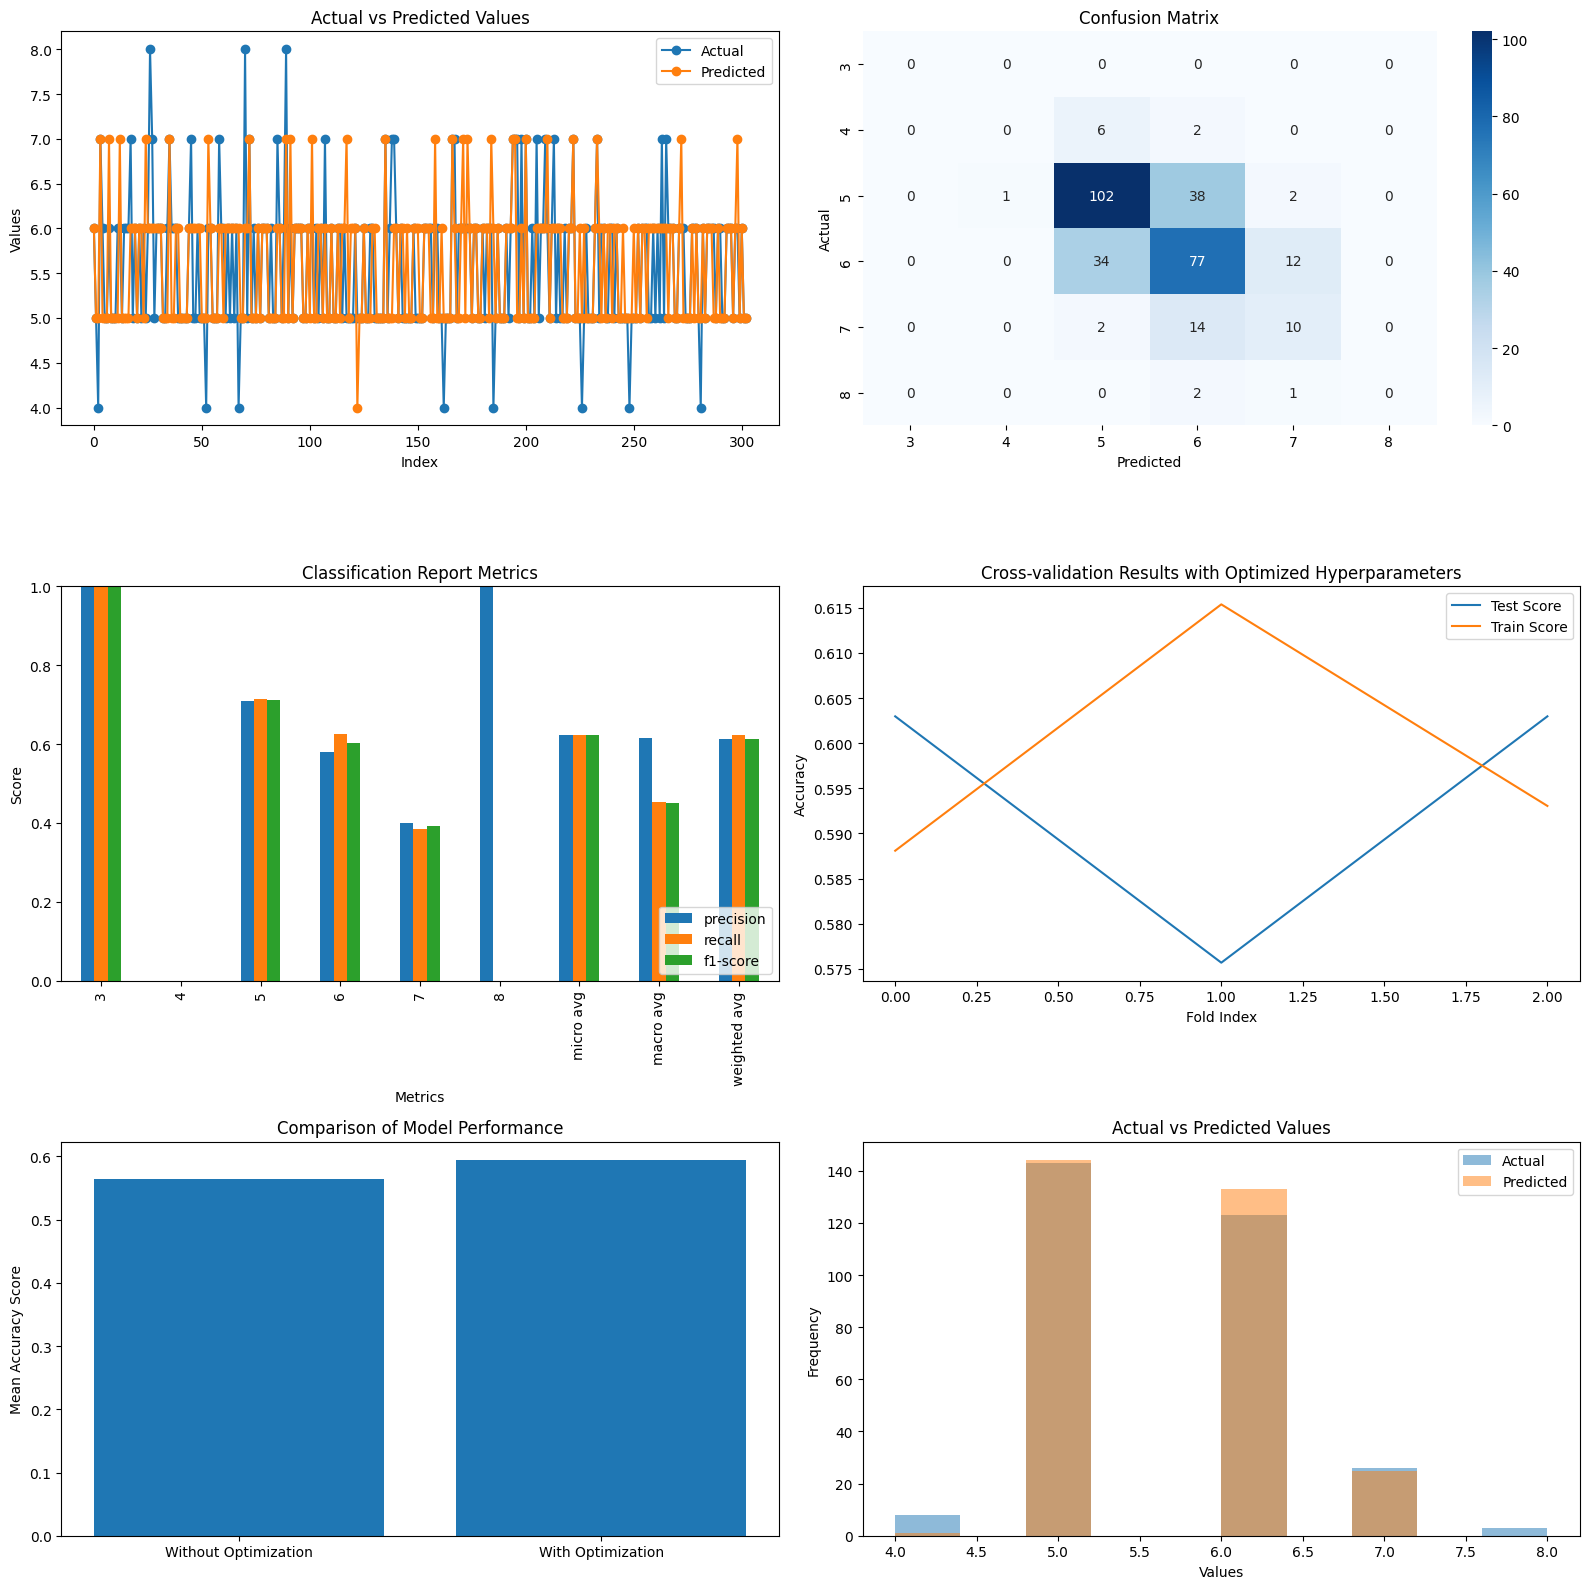

2024-06-16 20:17:56,640 - INFO - X shape: (1512, 8), y shape: (1512,)
2024-06-16 20:17:56,642 - INFO - Data scaled using standard scaler.
2024-06-16 20:17:56,658 - INFO - Applied smote to handle class imbalance in the training data.
2024-06-16 20:17:56,659 - INFO - Data initialization and splitting complete.



**************************************************
Checking Random Forest model
**************************************************



2024-06-16 20:17:58,172 - INFO - Cross-validation results: {'fit_time': array([0.45290756, 0.40770125, 0.54965854]), 'score_time': array([0.01311374, 0.01165795, 0.01508021]), 'test_score': array([0.86172345, 0.87875752, 0.86272545]), 'train_score': array([1., 1., 1.])}


Fitting 5 folds for each of 600 candidates, totalling 3000 fits


2024-06-16 20:22:00,301 - INFO - Best accuracy score: 87.81%
2024-06-16 20:22:00,301 - INFO - Best parameters: {'n_estimators': 87, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 19, 'class_weight': 'balanced', 'bootstrap': False}
2024-06-16 20:22:02,341 - INFO - Cross-validation results: {'fit_time': array([0.75462174, 0.63800025, 0.54762721]), 'score_time': array([0.01512003, 0.01025391, 0.00823545]), 'test_score': array([0.87775551, 0.87174349, 0.86272545]), 'train_score': array([1., 1., 1.])}
2024-06-16 20:22:02,361 - INFO - Classification report:
              precision    recall  f1-score   support

           3       0.00      1.00      0.00         0
           4       0.33      0.12      0.18         8
           5       0.80      0.76      0.78       143
           6       0.68      0.70      0.69       123
           7       0.50      0.65      0.57        26
           8       0.33      0.33      0.33         3

    accuracy             

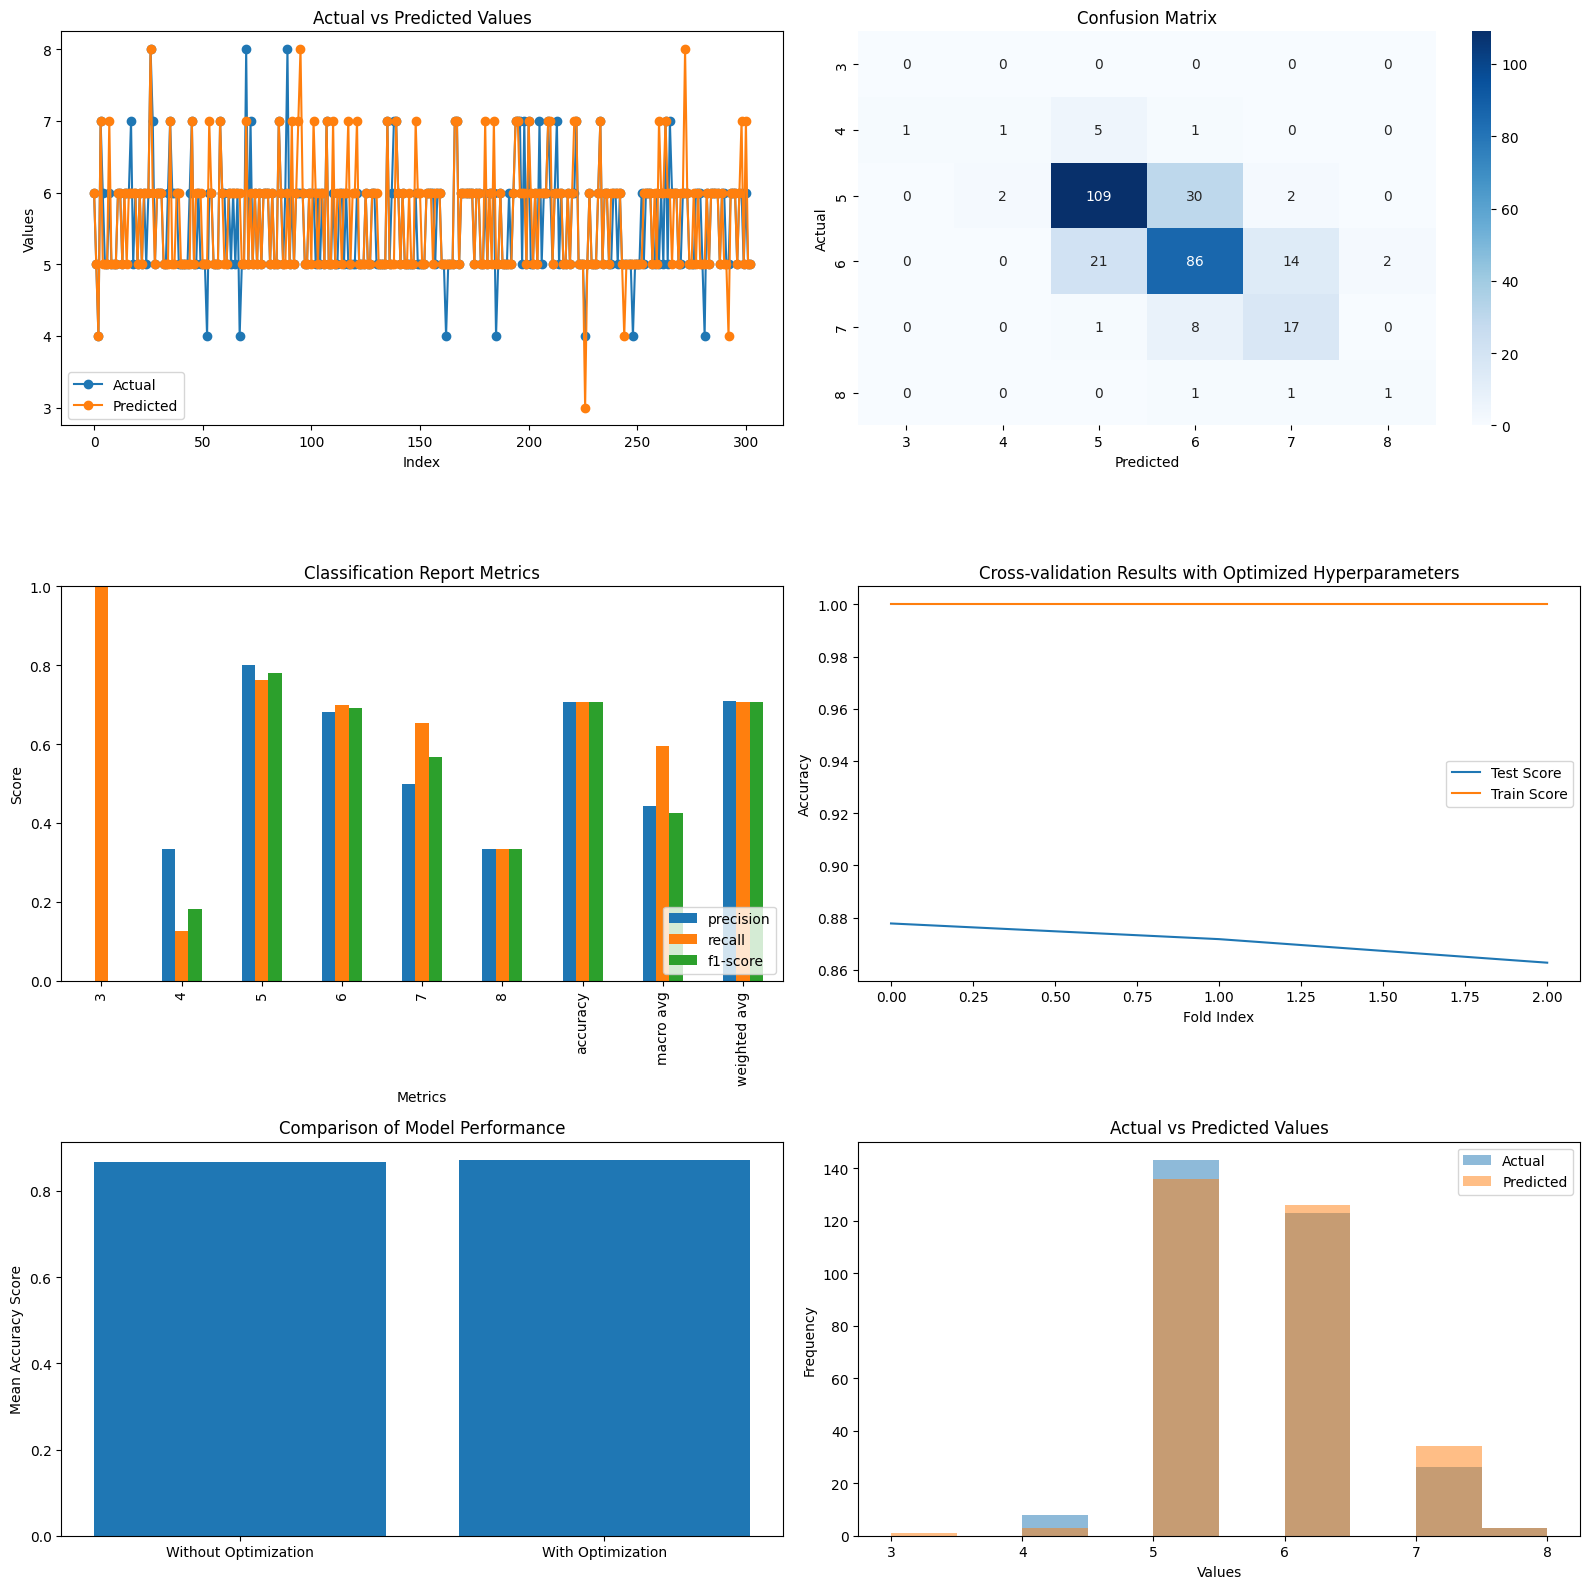

2024-06-16 20:22:03,631 - INFO - X shape: (1512, 8), y shape: (1512,)
2024-06-16 20:22:03,641 - INFO - Data scaled using standard scaler.
2024-06-16 20:22:03,668 - INFO - Applied smote to handle class imbalance in the training data.
2024-06-16 20:22:03,671 - INFO - Data initialization and splitting complete.



**************************************************
Checking K-Nearest Neighbors model
**************************************************



2024-06-16 20:22:04,161 - INFO - Cross-validation results: {'fit_time': array([0.        , 0.00299025, 0.00258589]), 'score_time': array([0.05784893, 0.05651569, 0.04818106]), 'test_score': array([0.76452906, 0.79258517, 0.79258517]), 'train_score': array([0.85721443, 0.85470942, 0.84669339])}


Fitting 5 folds for each of 600 candidates, totalling 3000 fits


2024-06-16 20:23:10,696 - INFO - Best accuracy score: 86.31%
2024-06-16 20:23:10,696 - INFO - Best parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 2, 'n_jobs': None, 'metric': 'euclidean', 'leaf_size': 20, 'algorithm': 'brute'}
2024-06-16 20:23:10,808 - INFO - Cross-validation results: {'fit_time': array([0.00452185, 0.00204182, 0.        ]), 'score_time': array([0.00996518, 0.01169682, 0.01458144]), 'test_score': array([0.84869739, 0.86673347, 0.87074148]), 'train_score': array([1., 1., 1.])}
2024-06-16 20:23:10,847 - INFO - Classification report:
              precision    recall  f1-score   support

           3       0.00      1.00      0.00         0
           4       0.00      0.00      0.00         8
           5       0.80      0.74      0.77       143
           6       0.68      0.58      0.63       123
           7       0.40      0.73      0.51        26
           8       0.11      0.33      0.17         3

    accuracy                           0.65       303


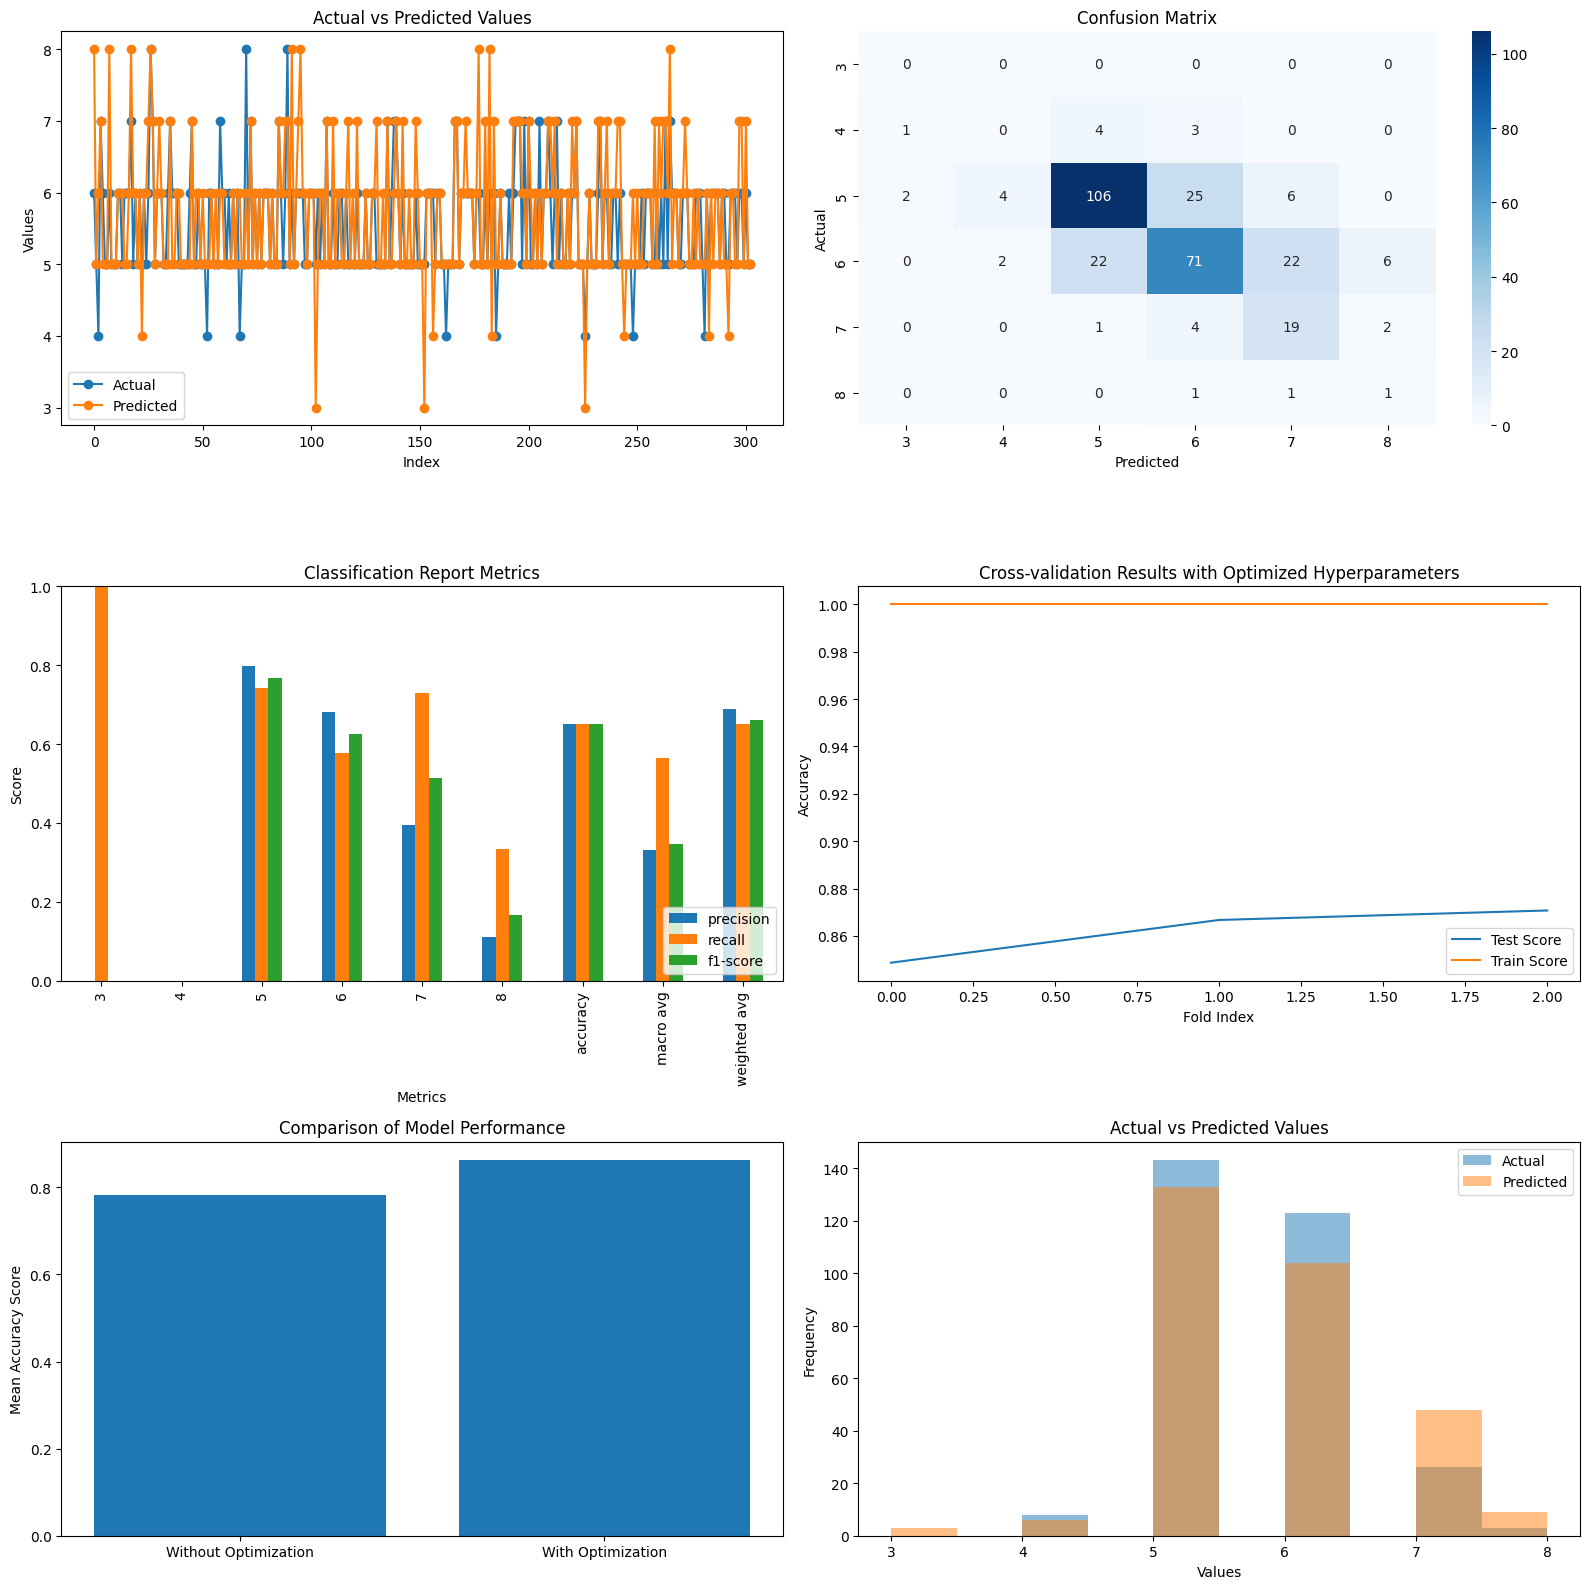

2024-06-16 20:23:12,371 - INFO - X shape: (1512, 8), y shape: (1512,)
2024-06-16 20:23:12,371 - INFO - Data scaled using standard scaler.
2024-06-16 20:23:12,391 - INFO - Applied smote to handle class imbalance in the training data.
2024-06-16 20:23:12,401 - INFO - Data initialization and splitting complete.
2024-06-16 20:23:16,951 - INFO - Model fitting complete.
2024-06-16 20:23:16,965 - INFO - Prediction complete.
2024-06-16 20:23:16,981 - INFO - Classification report:
              precision    recall  f1-score   support

           3       0.00      1.00      0.00         0
           4       0.00      0.00      0.00         8
           5       0.81      0.80      0.80       143
           6       0.72      0.72      0.72       123
           7       0.50      0.62      0.55        26
           8       0.33      0.33      0.33         3

    accuracy                           0.73       303
   macro avg       0.39      0.58      0.40       303
weighted avg       0.72      0.73  

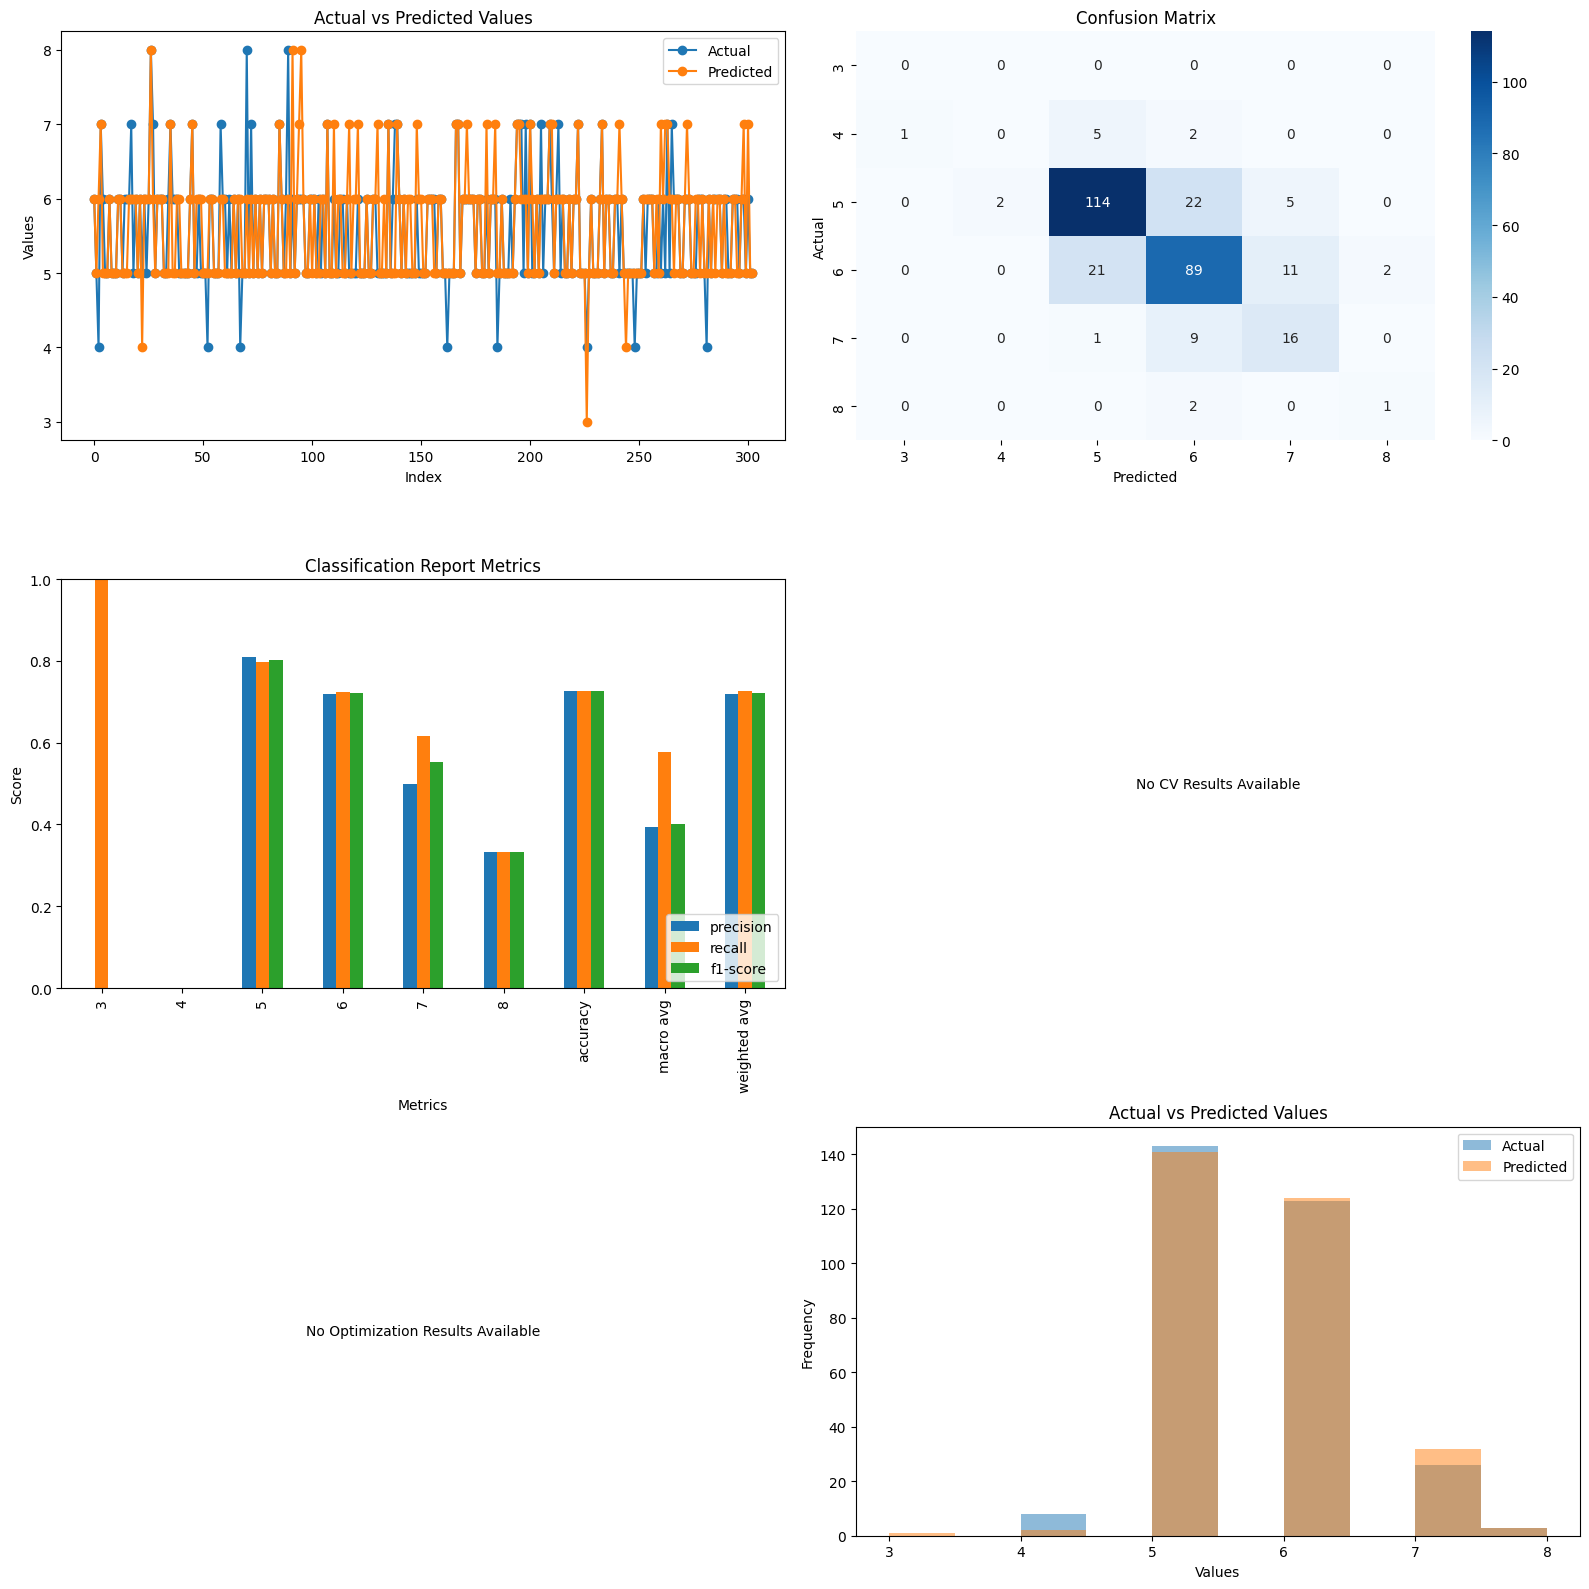

In [338]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import SelectFromModel

def ensemble_main(clf1, clf2, clf3):
    try:
        X_train, X_test, y_train, y_test = initialize_and_split_data("standard", 'smote', False)
        logging.info("Data initialization and splitting complete.")

        # Use stacking
        estimators = [('gnb', clf1), ('rf', clf2), ('knn', clf3)]
        eclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
        # eclf = VotingClassifier(estimators=estimators, voting='soft', weights=[3, 1, 1])

        # Fit the model to the training data
        eclf.fit(X_train, y_train)
        logging.info("Model fitting complete.")

        y_pred = eclf.predict(X_test)
        logging.info("Prediction complete.")

        report = generate_report(y_test, y_pred)
        logging.info("Report generation complete.")

        logging.info("Displaying plots for the ensemble model.")
        display_plots(y_test, y_pred, report, {}, 0, 0)

    except Exception as e:
        logging.error("An error occurred during model evaluation and plotting.", exc_info=True)

if __name__ == "__main__":
    print("\n" + "*" * 50)
    print("Checking Gaussian Naive Bayes model")
    print("*" * 50 + "\n")
    clf1 = gaussian_naive_bayes_main()

    print("\n" + "*" * 50)
    print("Checking Random Forest model")
    print("*" * 50 + "\n")
    clf2 = random_forest_main()

    print("\n" + "*" * 50)
    print("Checking K-Nearest Neighbors model")
    print("*" * 50 + "\n")
    clf3 = knn_main()

    ensemble_main(clf1, clf2, clf3)